# Using Markov transition fields and network graphs to uncover time series behavior
Markov transition fields (MTF) is a visualization technique to highlight behavior of time series. This notebook dives into how we build and interpret these fields. We will then further build on top of MTF by exploring network graphs interpretation.

## Initialization
---
### Notebook instance update

In [39]:
# This is a time series imaging analysis module:
!pip install --upgrade tsia

In [40]:
# Restart notebook kernel:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

### Imports

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

from matplotlib import gridspec
from numba import njit, prange
from pyts.image import MarkovTransitionField

import tsia.plot
import tsia.markov
import tsia.network_graph

In [42]:
%matplotlib inline
plt.style.use('Solarize_Light2')

## Loading data of interest
---

### Load tag time series

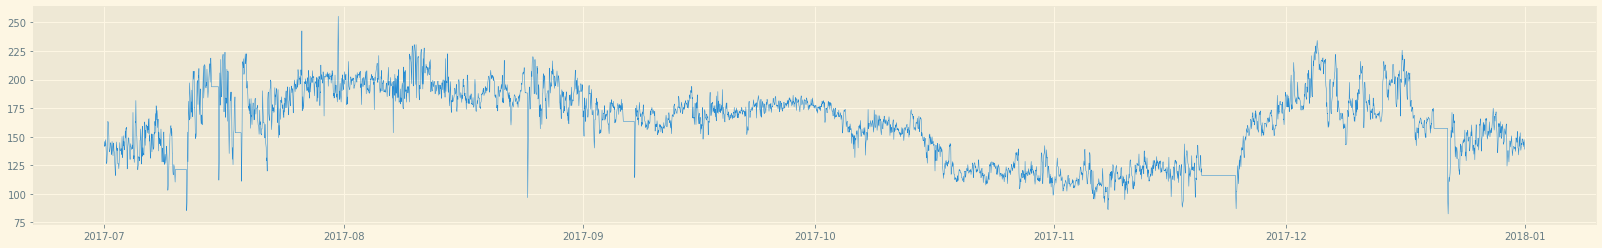

In [43]:
DATA = 'data'
tag_df = pd.read_csv(os.path.join(DATA, 'signal-1.csv'))
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
tag_df = tag_df.set_index('timestamp')

fig = plt.figure(figsize=(28,4))
plt.plot(tag_df, linewidth=0.5)
plt.show()

## Markov Transition Fields (MTF)
---
### MTF overview

The `pyts` package includes some time series imaging capabilities out of the box, like the **Markov Transition Fields**:

In [44]:
n_bins = 8
strategy = 'quantile'
X = tag_df.values.reshape(1, -1)
n_samples, n_timestamps = X.shape

mtf = MarkovTransitionField(image_size=48, n_bins=n_bins, strategy=strategy)
tag_mtf = mtf.fit_transform(X)

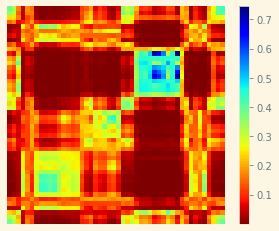

In [45]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111)
_, mappable_image = tsia.plot.plot_markov_transition_field(mtf=tag_mtf[0], ax=ax, reversed_cmap=True)
plt.colorbar(mappable_image);

### Process decomposition
In the following sections, we are going to decompose the way a Markov transition fields is built to better understand its properties and how it can be used to build our understanding of time series behavior:

1. Discretize the timeseries along the different values it can take
2. Build the Markov transition **matrix**
3. Compute transition probabilities
4. Compute the Markov transition **field**
5. Compute an aggregated MTF
6. Extracting metrics
7. Mapping transition probabilities back to the initial signals

#### **1 -** Discretization

In [46]:
X_binned, bin_edges = tsia.markov.discretize(tag_df)

Each value `x[i]` of the timeseries is associated to one of the bin (quantile) we just computed:

In [47]:
X_binned

array([2, 2, 2, ..., 2, 2, 2])

The first and the last bin edges respectively correspond to the lowest and highest value taken by the signal. The intermediate bin edges are computed by the discretizer. This  quantization process bins the different values taken by this signal in the following bins:

In [48]:
bin_edges

array([ 82.4318845 , 118.41579271, 137.42079667, 156.7783225 ,
       166.35528917, 175.224915  , 183.85208333, 196.53184021,
       255.378145  ])

Let's plot these bins over the time series to visualize how the values are discretized:

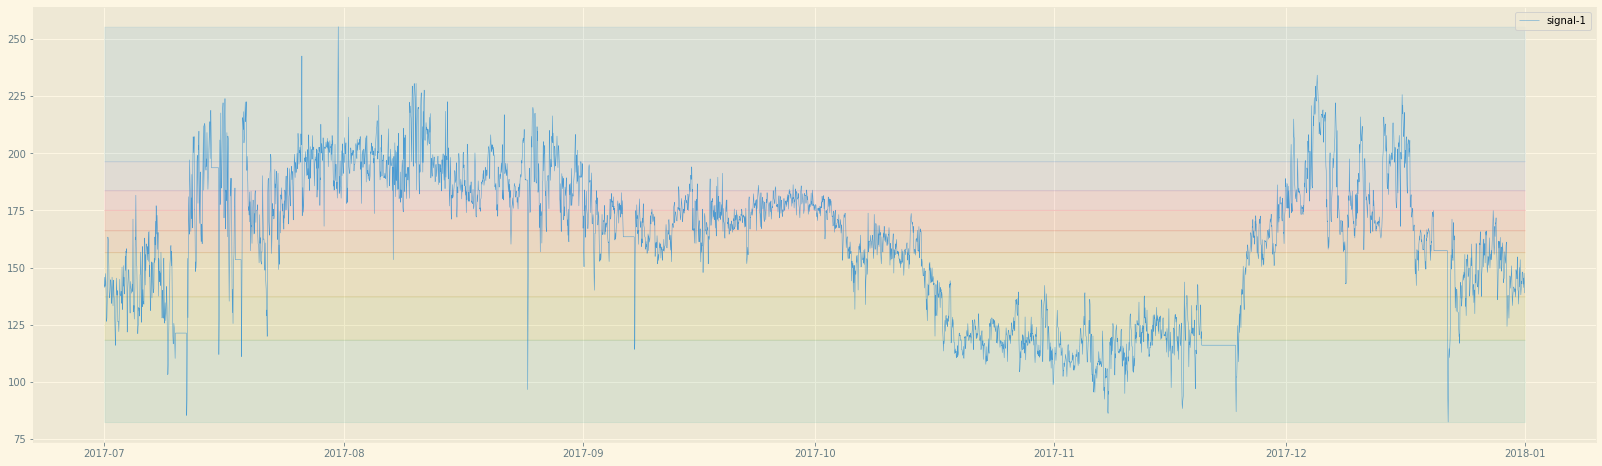

In [49]:
tsia.plot.plot_timeseries_quantiles(tag_df, bin_edges, label='signal-1')
plt.legend();

#### **2 -** Build the Markov transition matrix

In [50]:
X_mtm = tsia.markov.markov_transition_matrix(X_binned)
X_mtm

array([[465.,  86.,   1.,   0.,   0.,   0.,   0.,   0.],
       [ 80., 405.,  63.,   2.,   0.,   2.,   0.,   0.],
       [  3.,  59., 379.,  96.,   9.,   2.,   2.,   1.],
       [  2.,   2.,  94., 352.,  75.,  19.,   6.,   2.],
       [  0.,   0.,  12.,  89., 314., 110.,  23.,   4.],
       [  0.,   0.,   0.,   9., 125., 312.,  86.,  20.],
       [  2.,   0.,   2.,   4.,  21.,  89., 320., 114.],
       [  0.,   0.,   0.,   0.,   8.,  18., 115., 411.]])

**How to read the Markov transition matrix?** Let's have a look at the first row: **`| 465 | 86 | 1 | 0 | 0 | 0 | 0 | 0 |`**.

* The first cell tells us that 465 points that are in the bin 0 (with values between 82.43 and 118.42) are followed by a value that stays in this very bin.
* The second cell tells us that 86 points that are in bin 0 transition to the next bin (with a value between 118.42 and 137.42)
* ...
* The eighth cell tells us that no point from bin 0 transition to the last bin

Let's now have a look at the second row: **`| 80 | 405 | 63 | 2 | 0 | 2 | 0 | 0 |`**. The first cell tells us that 80 points that are in bin 1 (with a value between 118.42 and 137.42) are followed by a value that is in bin 0 (between 82.43 and 118.42)

The diagonal captures the frequency at which a quantile transitions to itself (*self-transition frequency*).

#### **3 -** Compute transition probabilities

**Normalization**: we will now normalize each bin. This matrix contains now the transition probability on the magnitude axis.

In [51]:
X_mtm = tsia.markov.markov_transition_probabilities(X_mtm)
np.round(X_mtm * 100, 1)

array([[84.2, 15.6,  0.2,  0. ,  0. ,  0. ,  0. ,  0. ],
       [14.5, 73.4, 11.4,  0.4,  0. ,  0.4,  0. ,  0. ],
       [ 0.5, 10.7, 68.8, 17.4,  1.6,  0.4,  0.4,  0.2],
       [ 0.4,  0.4, 17. , 63.8, 13.6,  3.4,  1.1,  0.4],
       [ 0. ,  0. ,  2.2, 16.1, 56.9, 19.9,  4.2,  0.7],
       [ 0. ,  0. ,  0. ,  1.6, 22.6, 56.5, 15.6,  3.6],
       [ 0.4,  0. ,  0.4,  0.7,  3.8, 16.1, 58. , 20.7],
       [ 0. ,  0. ,  0. ,  0. ,  1.4,  3.3, 20.8, 74.5]])

The first column correspond to the probabilities that a given value (part of a given bin) transitions to bin 0. The second column are probabilities that a given value transitions to bin 1, etc. For instance, if a given value `X[i]` is equal to **130.0**, it is between **118.42 and 137.42** and it's binned in bin 1. Given the matrix above, there is:
* A **14.5%** chance that the next value will be between **82.43 and 118.42** (bin 0)
* A **73.4%** chance to stay within the same range (between **118.42 and 137.42**, bin 1)
* A **11.4%** chance that the next value will be between **137.42 and 156.78** (bin 2)
* Etc.

#### **4 -** Compute the Markov transition **field**
The idea of the transition field is to represent the Markov transition probabilities sequentially to preserve the information in the time domain. The MTF generation process aligns each probability along the temporal order to build the MTF for the whole signal:

In [52]:
@njit()
def _markov_transition_field(X_binned, X_mtm, n_timestamps, n_bins):
    X_mtf = np.zeros((n_timestamps, n_timestamps))
    
    # We loop through each timestamp twice to build a N x N matrix:
    for i in prange(n_timestamps):
        for j in prange(n_timestamps):
            # We align each probability along the temporal order: MTF(i,j) 
            # denotes the transition probability of the bin 'i' to the bin 
            # 'j':
            X_mtf[i, j] = X_mtm[X_binned[i], X_binned[j]]
            
    return X_mtf

X_mtf = _markov_transition_field(X_binned, X_mtm, n_timestamps, n_bins)
np.round(X_mtf * 100, 1)

array([[68.8, 68.8, 68.8, ..., 68.8, 68.8, 68.8],
       [68.8, 68.8, 68.8, ..., 68.8, 68.8, 68.8],
       [68.8, 68.8, 68.8, ..., 68.8, 68.8, 68.8],
       ...,
       [68.8, 68.8, 68.8, ..., 68.8, 68.8, 68.8],
       [68.8, 68.8, 68.8, ..., 68.8, 68.8, 68.8],
       [68.8, 68.8, 68.8, ..., 68.8, 68.8, 68.8]])

**How to read the Markov transition field?** **`MTF[i,j]`** denotes the transition probability from the quantile **`q[i]`** to the quantile **`q[j]`**. Let's have a look at a couple values in the second row of this field:

In [53]:
second_row = np.round(X_mtf * 100, 1)[1]
second_row[0:10]

array([68.8, 68.8, 68.8, 68.8, 68.8, 68.8, 10.7, 10.7, 10.7, 10.7])

Let's have a look at **`M[1,2]`**:

* We look in which bin falls the signal at timestep **`x[1]`**: this is **`X_binned[1] = 2`**
* We also look in which bin falls the signal at timestep **`x[2]`**: this is **`X_binned[2] = 2`**
* We then look up into the Markov transition matrix to get the probability that a value from bin 2 stays into bin 2
* This value is **68.8%**, hence **`M[1,2] = 68.8%`**

What does this mean? Well, the transition that occurs between timestep `x[1]` and timestamp `x[2]` has an **68.8%** chance from happening when looking at the whole signal.

Let's now have a look at **`M[1,6]`**:

* We look in which bin falls the signal at timestep **`x[1]`**: this is **`X_binned[1] = 2`**
* We also look in which bin falls the signal at timestep **`x[10]`**: this is **`X_binned[6] = 1`**
* We then look up into the Markov transition matrix to get the probability that a value from bin 2 transitions into bin 1
* This value is **10.7%**, hence **`M[1,6] = 10.7%`**

The transition that happens between timestep `x[1]` and `x[6]` has a **10.7%** chance of happening when looking at the whole signal.

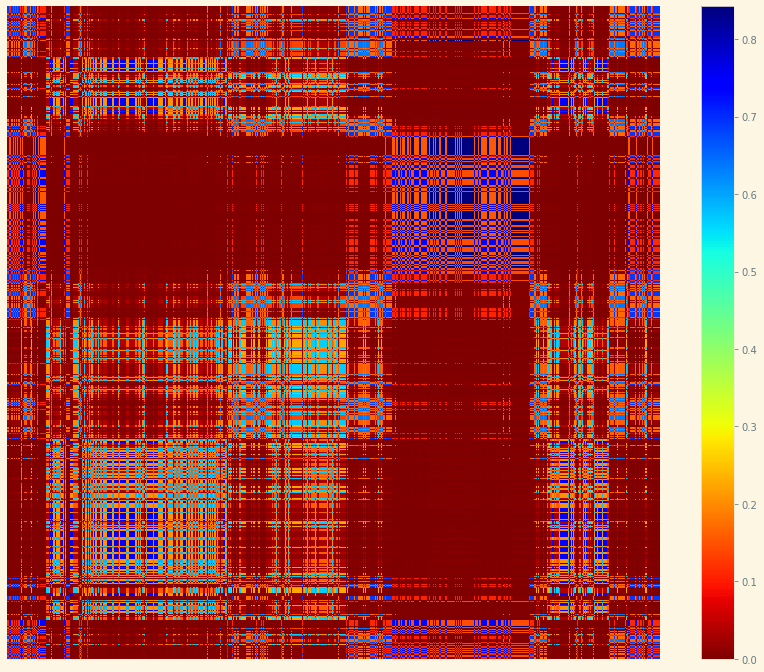

In [54]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(1,1,1)
_, mappable_image = tsia.plot.plot_markov_transition_field(mtf=X_mtf, ax=ax, reversed_cmap=True)
plt.colorbar(mappable_image);

#### **5 -** Compute an aggregated MTF

To make the image size manageable and computation more efficient *(the above MTF is a matrix of dimension 4116 x 4116)*, we reduce the MTF size by averaging the pixels in each non-overlapping `m x m` patch with the blurring kernel `1/m²`. `m` is the image size and we set it, arbitrarily, to 48 above. That is, we aggregate the transition probabilities in each subsequence of length `m = 48` together. Let's compute an aggregated MTF accordingly:

In [55]:
image_size = 48
window_size, remainder = divmod(n_timestamps, image_size)

if remainder == 0:
    X_amtf = np.reshape(
        X_mtf, (image_size, window_size, image_size, window_size)
    ).mean(axis=(1, 3))
    
else:
    # Needs to compute piecewise aggregate approximation in this case. This
    # is fully implemented in the pyts package
    pass

We can now plot the aggregated MTF and find the initial results obtained with the **`pyts.image`** Python module:

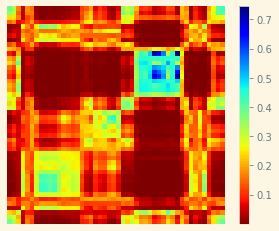

In [56]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
_, mappable_image = tsia.plot.plot_markov_transition_field(mtf=X_amtf, ax=ax, reversed_cmap=True)
plt.colorbar(mappable_image);

#### **6 -** Extracting metrics
The diagonal of the MTF contains probabilities for the self-transitions:
* Self-transition probabilities are probabilities to move from a quantile to the same one on the next timestep).
* We can extract the characteristic of this distribution (mean and standard deviation).
* The other diagonals of the MTF are harder to interpret but can still be plotted.

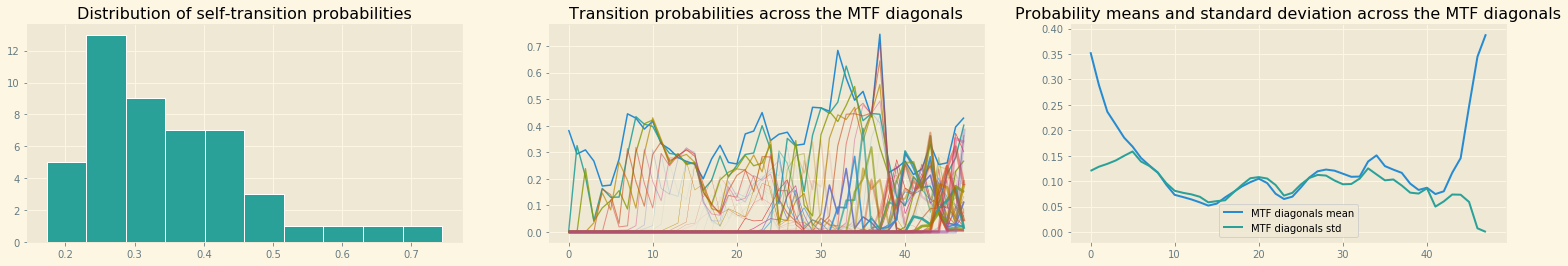

In [57]:
_ = tsia.plot.plot_mtf_metrics(X_amtf)

#### **7 -** Mapping transition probabilities back to the initial signals
One way we can map back these probabilities on the original signal, is to take the transition probabilities shown on the diagonal of the MTF:

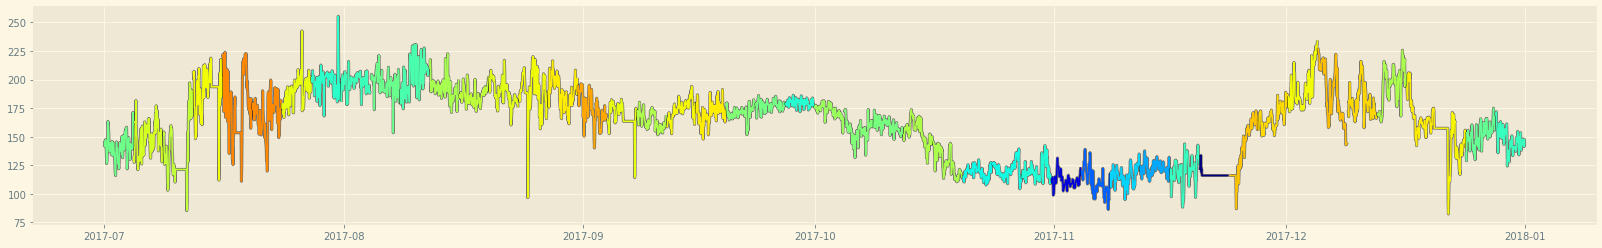

In [58]:
mtf_map = tsia.markov.get_mtf_map(tag_df, X_amtf, reversed_cmap=True)
_ = tsia.plot.plot_colored_timeseries(tag_df, mtf_map)

In [59]:
def plot_colored_timeseries(tag, image_size=96, colormap='jet'):
    # Loads the signal from disk:
    tag_df = pd.read_csv(os.path.join(DATA, f'{tag}.csv'))
    tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    tag_df = tag_df.set_index('timestamp')

    # Build the MTF for this signal:
    X = tag_df.values.reshape(1, -1)
    mtf = MarkovTransitionField(image_size=image_size, n_bins=n_bins, strategy=strategy)
    tag_mtf = mtf.fit_transform(X)

    # Initializing figure:
    fig = plt.figure(figsize=(28, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])

    # Plotting MTF:
    ax = fig.add_subplot(gs[0])
    ax.set_title('Markov transition field')
    _, mappable_image = tsia.plot.plot_markov_transition_field(mtf=tag_mtf[0], ax=ax, reversed_cmap=True)
    plt.colorbar(mappable_image)
    
    # Plotting signal:
    ax = fig.add_subplot(gs[1])
    ax.set_title(f'Signal timeseries for tag {tag}')
    mtf_map = tsia.markov.get_mtf_map(tag_df, tag_mtf[0], reversed_cmap=True, step_size=0)
    _ = tsia.plot.plot_colored_timeseries(tag_df, mtf_map, ax=ax)
        
    return tag_mtf

Let's have a look at a coarse MTF (`image_size=8` makes it quite coarse) to better understand what we can extract from this Markov field:

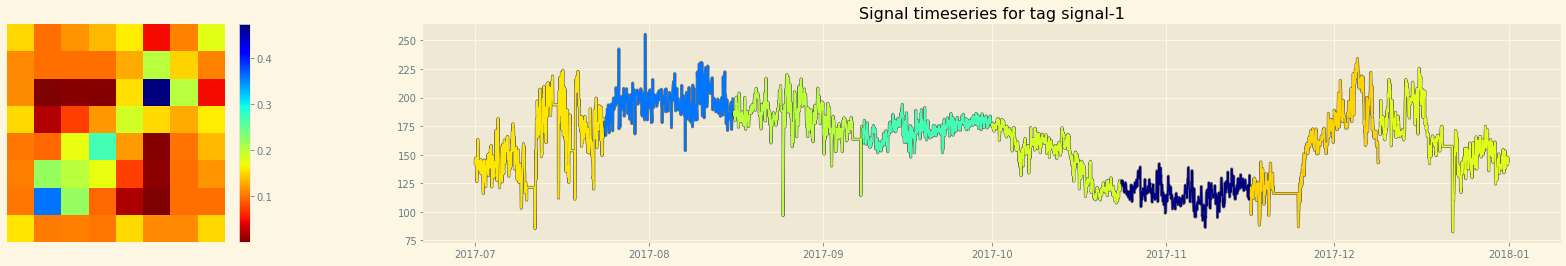

In [60]:
stats = []
mtf = plot_colored_timeseries('signal-1', image_size=8)
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-1'})
stats.append(s)

**What is the interpretation we can give to this plot?**
* In average, the average transition probabiliy of the first section (in yellow) is around 19%: this means that the transitions that we see in this section do not happen very often (19% of the time) when we look at the whole signal.
* In contrast, the section in dark blue (the sixth one), have transitions that happen more often in this signal (around 50% of the time)

**The blue section is closer to the normal behavior of this signal whereas the yellow section is diverging more from it.** Let's have a look at the results we can get with a less coarse MTF and also from other signals. Let's also plot the MTF metrics for each of these signals...

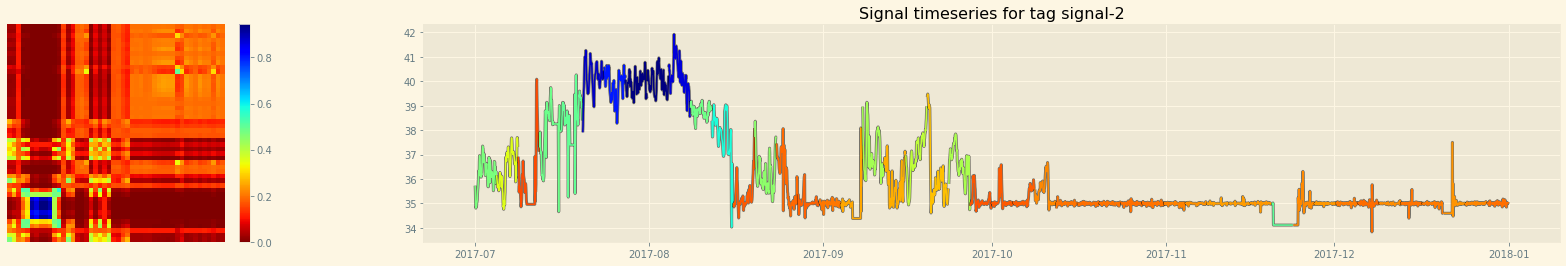

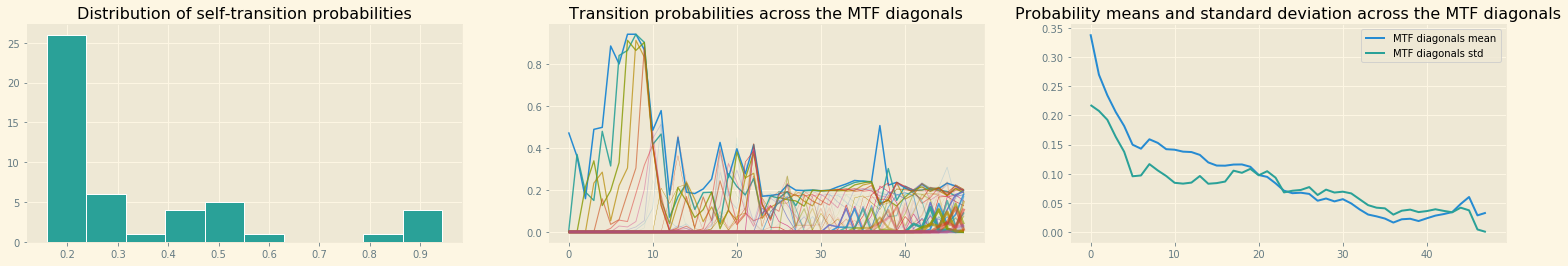

In [61]:
mtf = plot_colored_timeseries('signal-2', image_size=48)
_ = tsia.plot.plot_mtf_metrics(mtf[0])
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-2'})
stats.append(s)

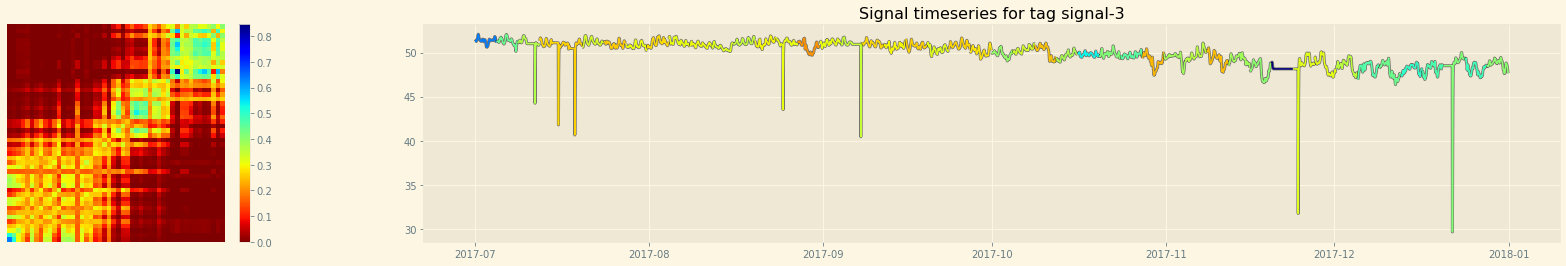

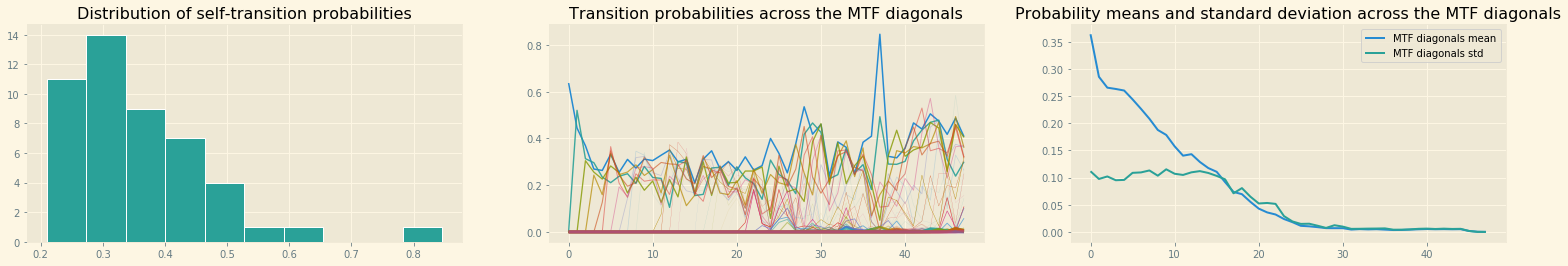

In [62]:
mtf = plot_colored_timeseries('signal-3', image_size=48)
_ = tsia.plot.plot_mtf_metrics(mtf[0])
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-3'})
stats.append(s)

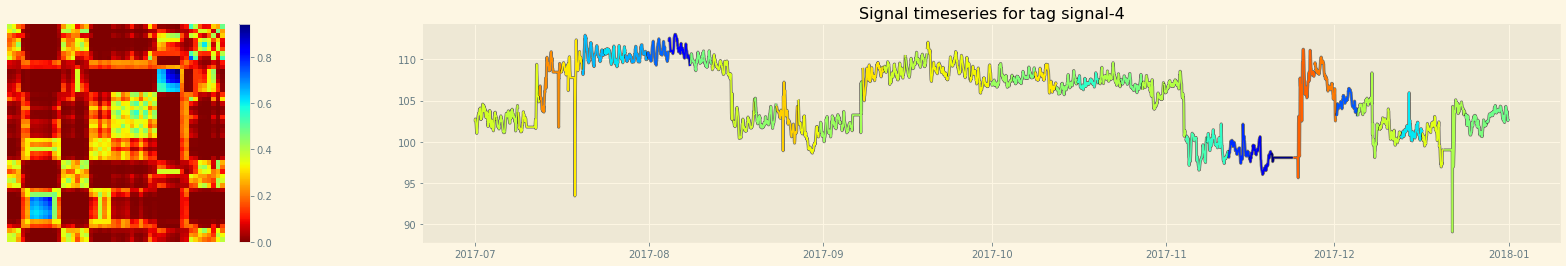

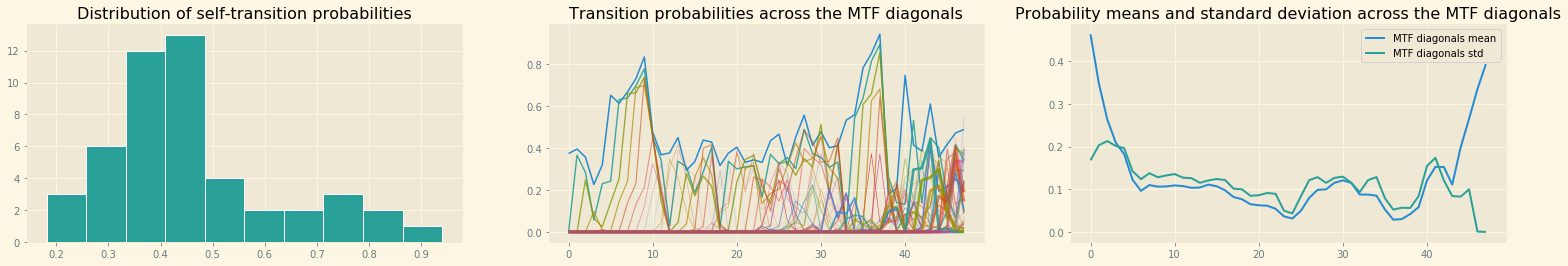

In [63]:
mtf = plot_colored_timeseries('signal-4', image_size=48)
_ = tsia.plot.plot_mtf_metrics(mtf[0])
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-4'})
stats.append(s)

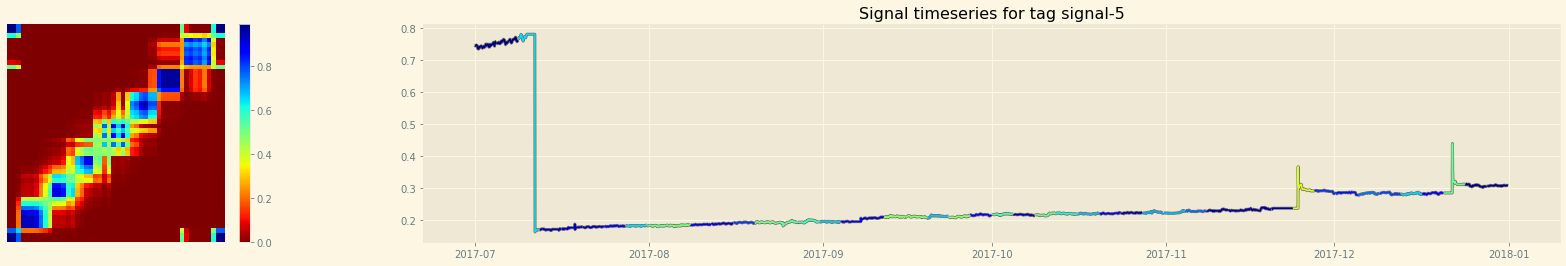

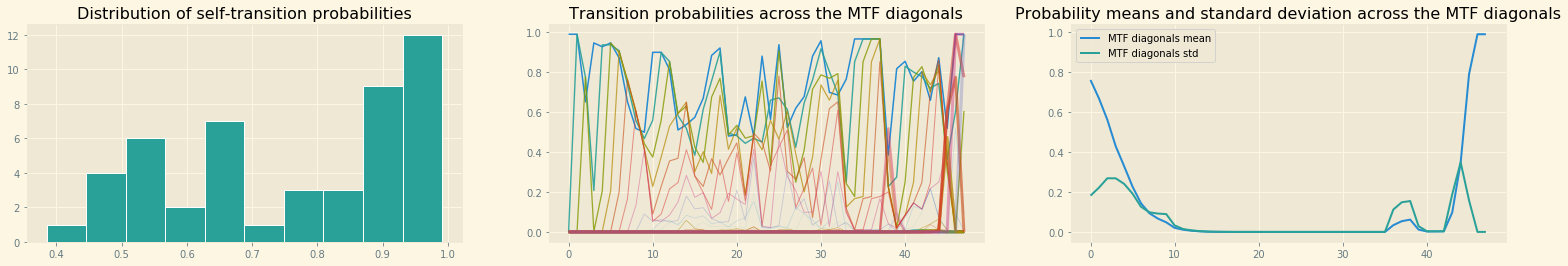

In [64]:
mtf = plot_colored_timeseries('signal-5', image_size=48)
_ = tsia.plot.plot_mtf_metrics(mtf[0])
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-5'})
stats.append(s)

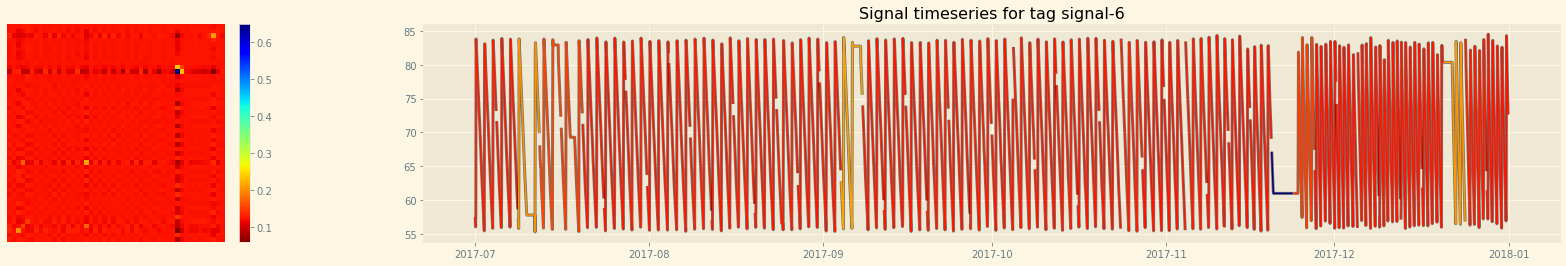

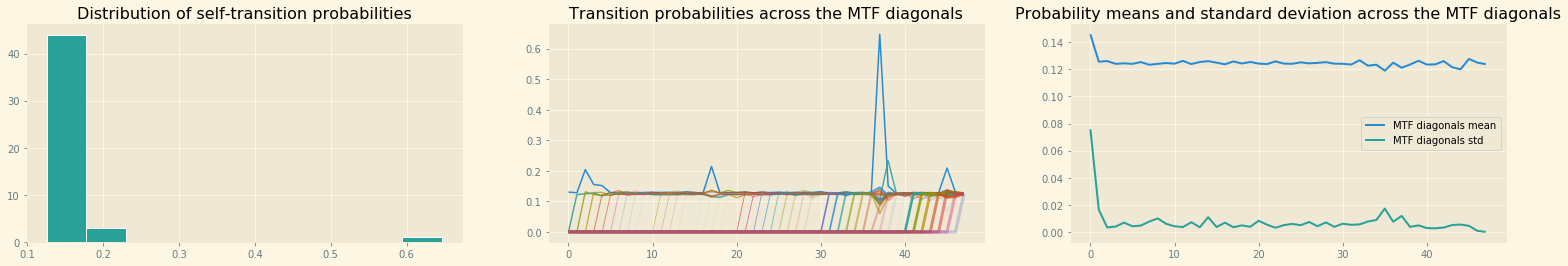

In [65]:
mtf = plot_colored_timeseries('signal-6', image_size=48)
_ = tsia.plot.plot_mtf_metrics(mtf[0])
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-6'})
stats.append(s)

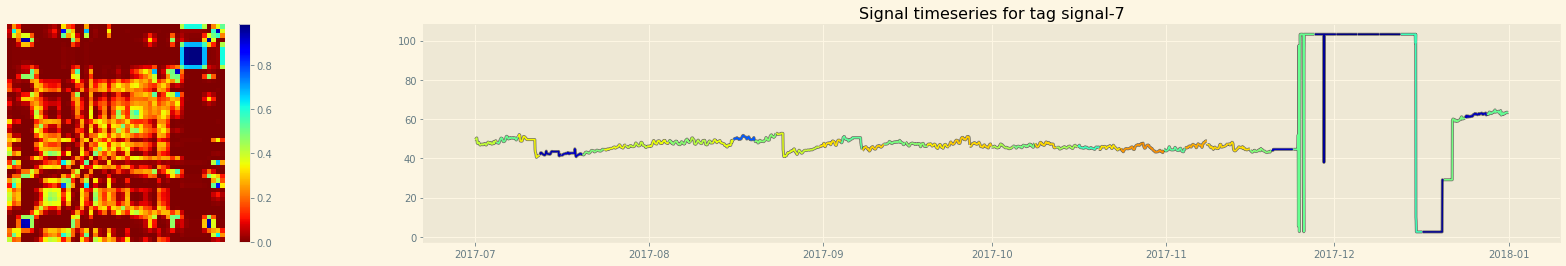

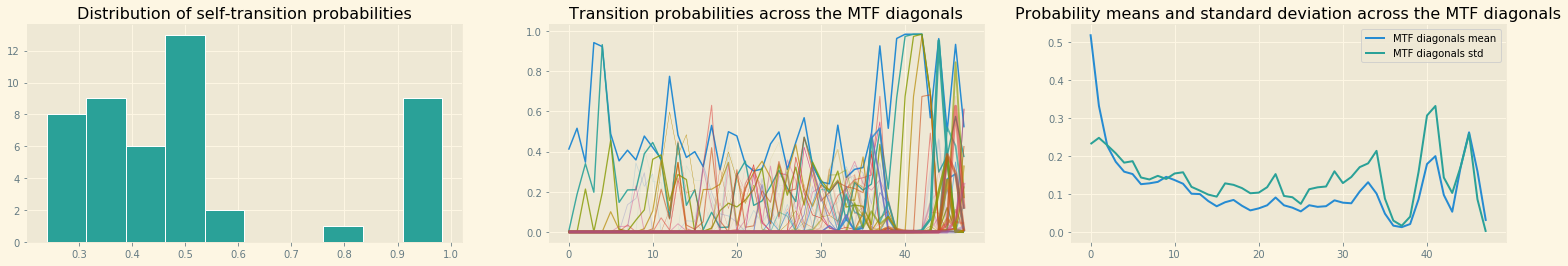

In [66]:
mtf = plot_colored_timeseries('signal-7', image_size=48)
_ = tsia.plot.plot_mtf_metrics(mtf[0])
s = tsia.markov.compute_mtf_statistics(mtf[0])
s.update({'Signal': 'signal-7'})
stats.append(s)

In [67]:
stats = pd.DataFrame(stats)
stats.set_index('Signal')

Average self-transition prob  Std self-transition prob
Signal                                                          
signal-1                      0.247135                  0.107224
signal-2                      0.339496                  0.217961
signal-3                      0.364138                  0.111733
signal-4                      0.463698                  0.167919
signal-5                      0.761621                  0.181839
signal-6                      0.145869                  0.075745
signal-7                      0.520029                  0.231163

## Network graphs
---
### Overview

From the MTF, we can generate a graph `G = (V, E)`: we have a direct mapping between vertex *V* and the time index *i*. From there, there is two possible encoding of interest:
* **Flow encoding:** this representation help us observe where do the big information flow occurs
    * We map the flow of time to the vertex, using a color gradient from T0 to TN to color each node of the network graph
    * We use the MTF weight to color the edges between vertices
* **Modularity encoding:** modularity is an important pattern in network analysis to identify specific local structures.
    * We map the module label (which *community ID*) to each vertex with a specific color attached to each community
    * We map the size of the vertices to a clustering coefficient
    * We map the edge color to the module label of the target vertex

Let's start by loading a first signal and gets its MTF:

In [68]:
tag_df = pd.read_csv(os.path.join(DATA, 'signal-1.csv'))
tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
tag_df = tag_df.set_index('timestamp')

image_size = 48
X = tag_df.values.reshape(1, -1)
mtf = MarkovTransitionField(image_size=image_size, n_bins=n_bins, strategy=strategy)
tag_mtf = mtf.fit_transform(X)

### Process decomposition
In the following sections, we are going to decompose the way a network graph is built to better understand its properties and how it can be used to build our understanding of time series behavior:

1. Build the network graph
2. Compute the partitions and modularity and encode this information in the network graph representation
3. Plot the network graph
4. Map the partitions color back to the time series

#### **1 -** Build the network graph

We extract the graph from the MTF and plot a vanilla network graph from there:

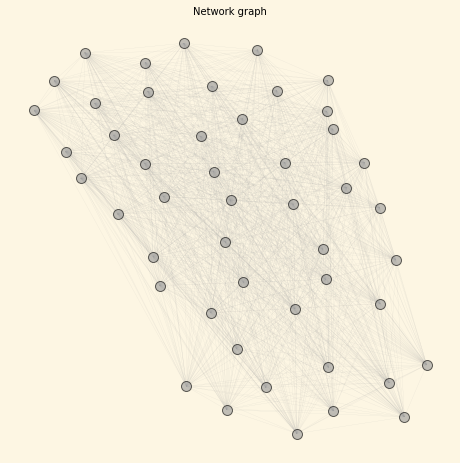

In [69]:
G = tsia.network_graph.get_network_graph(tag_mtf[0])
_ = tsia.plot.plot_network_graph(G, title='Network graph')

#### **2 -** Encode partitions and modularity into the network graph representation
The above network graph does not give us a lot of new insights. We will search for the communities in this network graph with the **[Louvain method](https://en.wikipedia.org/wiki/Louvain_method)**: **modularity** is a scale value between −0.5 (non-modular clustering) and 1 (fully modular clustering) that measures the relative density of edges inside communities with respect to edges outside communities. Optimizing this value theoretically results in the best possible grouping of the nodes of a given network, however going through all possible iterations of the nodes into groups is impractical so heuristic algorithms are used. In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node and the first step is repeated. This method is implemented in the `community` package (documented **[here](https://python-louvain.readthedocs.io/en/latest/)**) and we use it in the `tsia` package to encode our network graph:

In [70]:
encoding = tsia.network_graph.get_modularity_encoding(G)

On top of modularity and number of communities (or partitions), there are other statistics of interest we can compute from a network graph:

In [71]:
stats = tsia.network_graph.compute_network_graph_statistics(G)
stats

{'Diameter': 1,
 'Average degree': 48.0,
 'Average weighted degree': 46.273244774344036,
 'Density': 1.0425531914893618,
 'Average path length': 0.00650027056715701,
 'Average clustering coefficient': 0.10427714321139174,
 'Modularity': 0.3747117973757859,
 'Partitions': 4}

#### **3 -** Plot the network graph

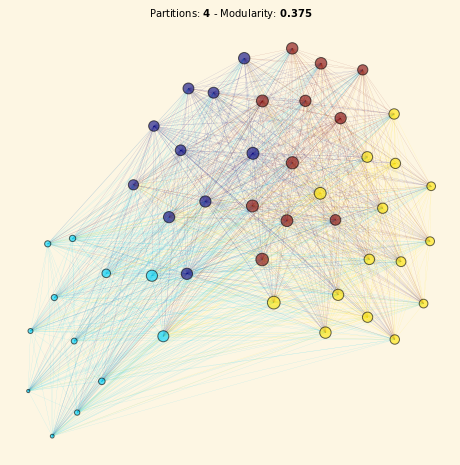

In [72]:
nb_partitions = stats['Partitions']
modularity = stats['Modularity']
title = rf'Partitions: $\bf{nb_partitions}$ - Modularity: $\bf{modularity:.3f}$'
_ = tsia.plot.plot_network_graph(G, title=title, encoding=encoding)

**What is the interpretation we can give to this plot?** The modularity metric and the Louvain methods uncovers 4 communities in this signal. At this stage, it is difficult to understand how we can leverage this knowledge though...

#### **5 -** Map the partitions color back to the time series

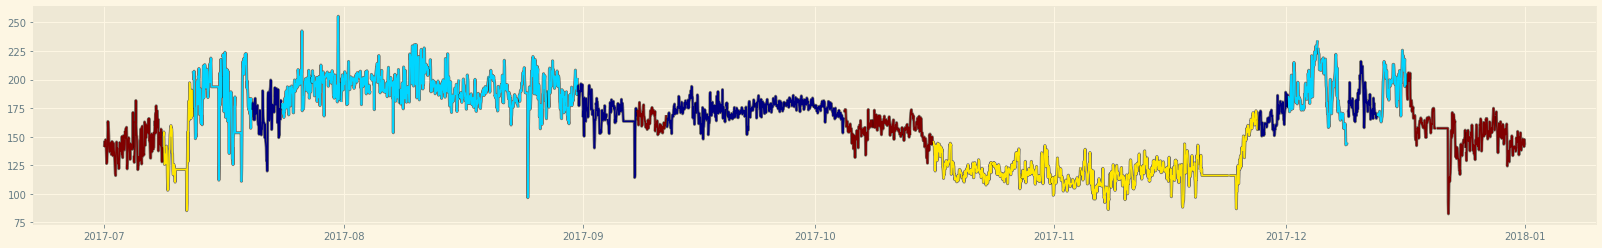

In [73]:
ng_map = tsia.network_graph.get_network_graph_map(tag_df, encoding, reversed_cmap=True)
_ = tsia.plot.plot_colored_timeseries(tag_df, ng_map)

Each community detected in the network graphs has its own shapelet in the original time series. Let's now further build our intuition by drawing the same plot for the other signals from before:

In [74]:
def plot_communities_timeseries(tag, image_size=48, colormap='jet'):
    # Loads the signal from disk:
    tag_df = pd.read_csv(os.path.join(DATA, f'{tag}.csv'))
    tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'], format='%Y-%m-%dT%H:%M:%S.%f')
    tag_df = tag_df.set_index('timestamp')
    
    X = tag_df.values.reshape(1, -1)
    mtf = MarkovTransitionField(image_size=image_size, n_bins=n_bins, strategy=strategy)
    tag_mtf = mtf.fit_transform(X)
    
    G = tsia.network_graph.get_network_graph(tag_mtf[0])
    statistics = tsia.network_graph.compute_network_graph_statistics(G)
    nb_partitions = statistics['Partitions']
    modularity = statistics['Modularity']
    encoding = tsia.network_graph.get_modularity_encoding(G, reversed_cmap=True)
    ng_map = tsia.network_graph.get_network_graph_map(tag_df, encoding, reversed_cmap=True)
    
    fig = plt.figure(figsize=(28, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,4])

    ax = fig.add_subplot(gs[0])
    title = rf'Partitions: $\bf{nb_partitions}$ - Modularity: $\bf{modularity:.3f}$'
    tsia.plot.plot_network_graph(G, ax=ax, title=title, reversed_cmap=True, encoding=encoding)
    
    ax = fig.add_subplot(gs[1])
    tsia.plot.plot_colored_timeseries(tag_df, ng_map, ax=ax)
    
    return statistics

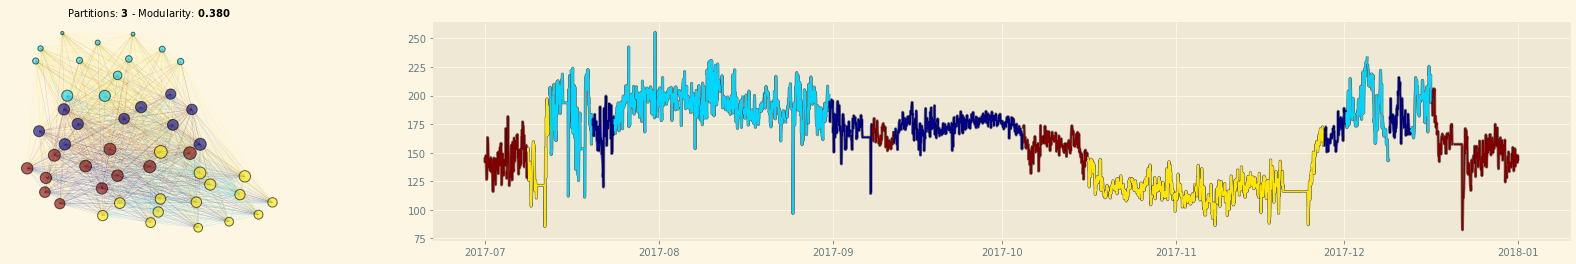

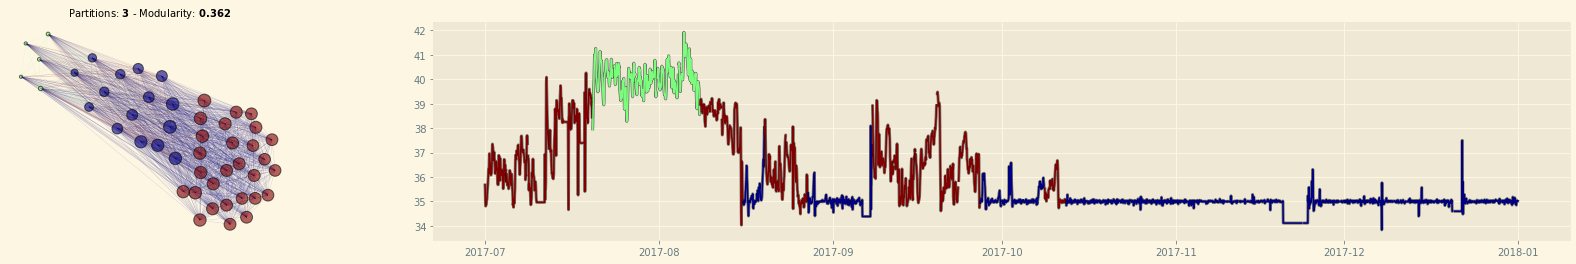

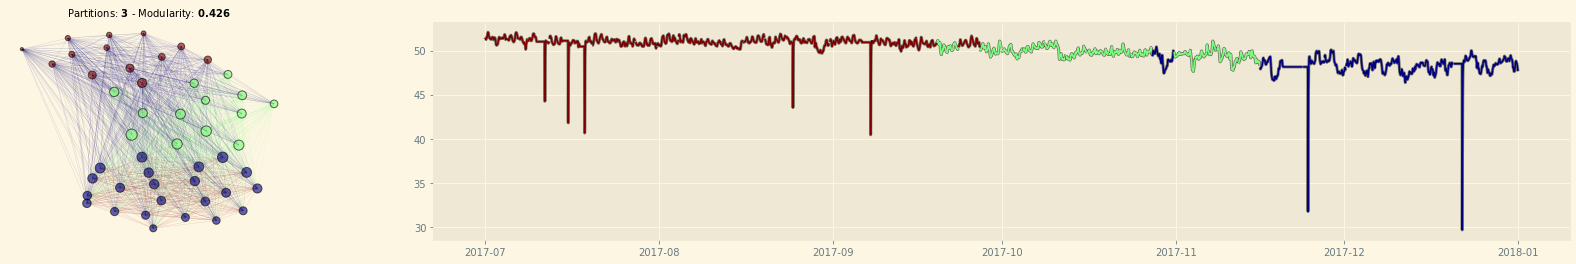

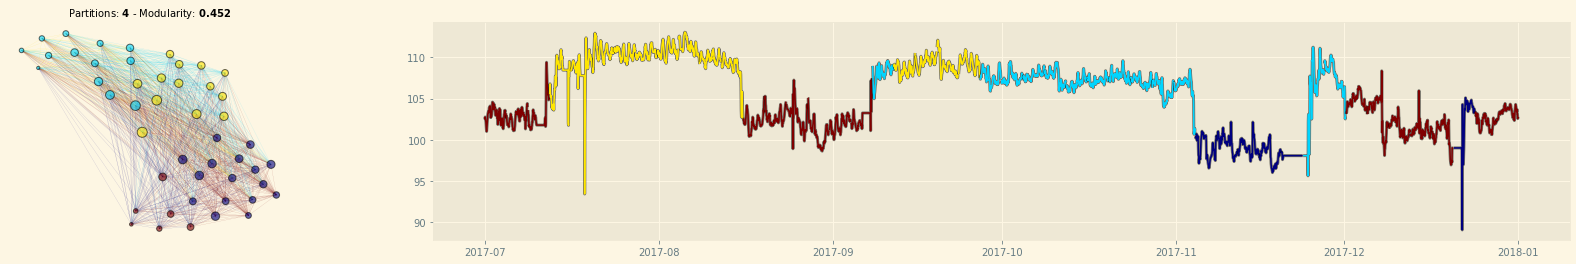

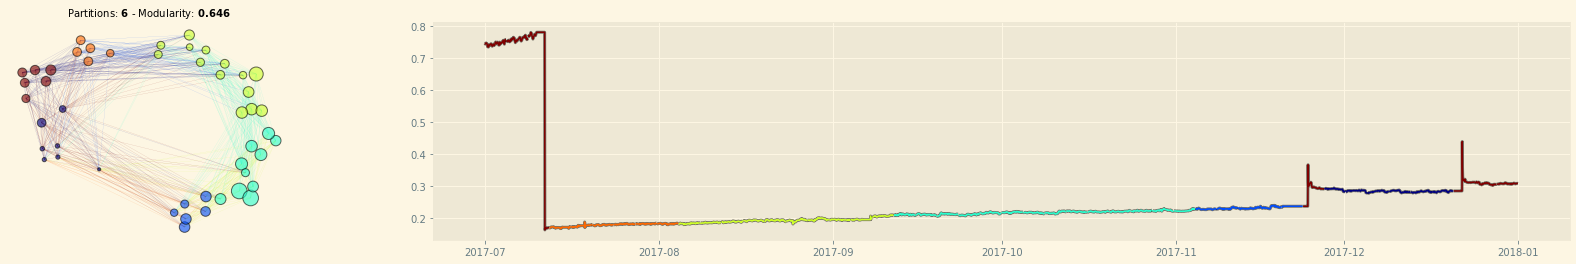

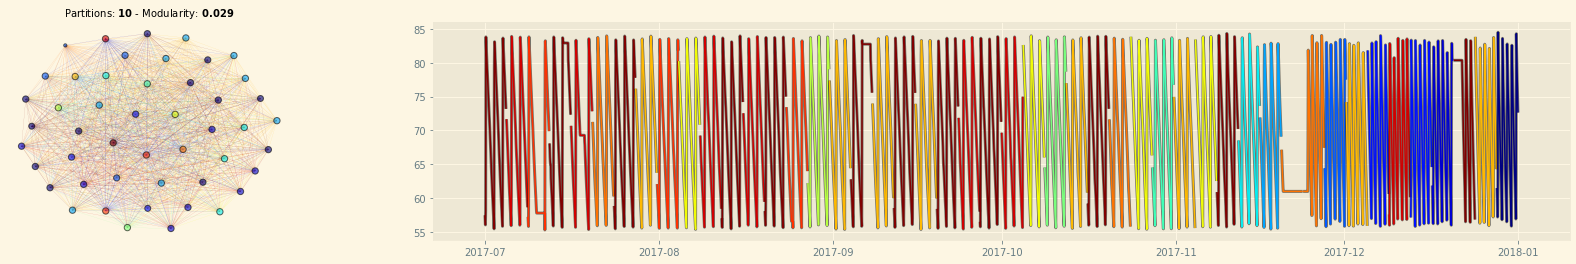

In [75]:
signals = [f'signal-{i}' for i in range(1,7)]

stats = []
for signal in signals:
    s = plot_communities_timeseries(signal)
    s.update({'Signal': signal})
    stats.append(s)

Features that can be extracted from network graphs:

In [76]:
stats = pd.DataFrame(stats)
stats.set_index('Signal')

Diameter  Average degree  Average weighted degree   Density  \
Signal                                                                  
signal-1         1       48.000000                46.273245  1.042553   
signal-2         2       47.923587                44.542867  1.040780   
signal-3         1       48.000000                46.195448  1.042553   
signal-4         2       47.047615                42.673551  1.015957   
signal-5         2       28.555861                25.891515  0.624113   
signal-6         1       48.000000                47.837075  1.042553   

          Average path length  Average clustering coefficient  Modularity  \
Signal                                                                      
signal-1             0.006500                        0.104277    0.380070   
signal-2             0.010023                        0.087930    0.362259   
signal-3             0.002377                        0.082852    0.425830   
signal-4             0.002286                        0.067332    0.451936   
signal-5             0.001180                        0.082179    0.645677   
signal-6             0.124502                        0.192393    0.028876   

          Partitions  
Signal                
signal-1           3  
signal-2           3  
signal-3           3  
signal-4           4  
signal-5           6  
signal-6          10

## Conclusion and future work
---

Mapping **Markov transition fields** transition probabilities back onto the time series signal appears like a great tool to provide feedback to end users about the behavior of a given signal. On the other hand, mapping network graphs communities back to original time series does not seem to bring much values: however, the features extracted from these networks graphs (see table above) will be interesting to use to automatically qualify the usability of the signals for a given use case. As one of the future area of investigation, we are interested into investigating how these tools could be applied to multivariate timeseries (especially highly dimensional ones as we can find in industrial settings with hundreds if not thousands of sensors per industrial equipment).

### Potential usage
Markov transition fields and network graphs could be potentially used:
* To mathematically qualify the characteristics of a given signal: is it constant, steady, noisy, monotonic...
* To compare training and validation dataset consistency (and detect concept drift).
* To train semi-supervised anomaly prediction models: train a temporal CNN on normal signals, perform and inline MTF calculation every minute (for instance) and compare inference results with the trained model to detect signal behavior change.
* To further explain why an unsupervised time series anomaly detection model found an anomaly

## References
---
* Wang, Zhiguang; Oates, Tim (2015), *Imaging Time-Series to Improve Classification and Imputation*, Arxiv
* Liu, Lu.; Wang, Zhiguang (2018) *Encoding temporal Markov dynamics in graph for visualizing and mining time series* Arxiv.